# 1. Import Dependencies and Data

In [142]:
# %pip install tensorflow-datasets==4.8.0

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus : 
   tf.config.experimental.set_memory_growth(gpu, True)

for gpu in gpus : 
   print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = tfds.load('fashion_mnist', split='train')

In [4]:
ds.as_numpy_iterator().next()['label']

2

# 2. Viz Data and Build Dataset

In [5]:
import numpy as np

In [6]:
dataiterator = ds.as_numpy_iterator()
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

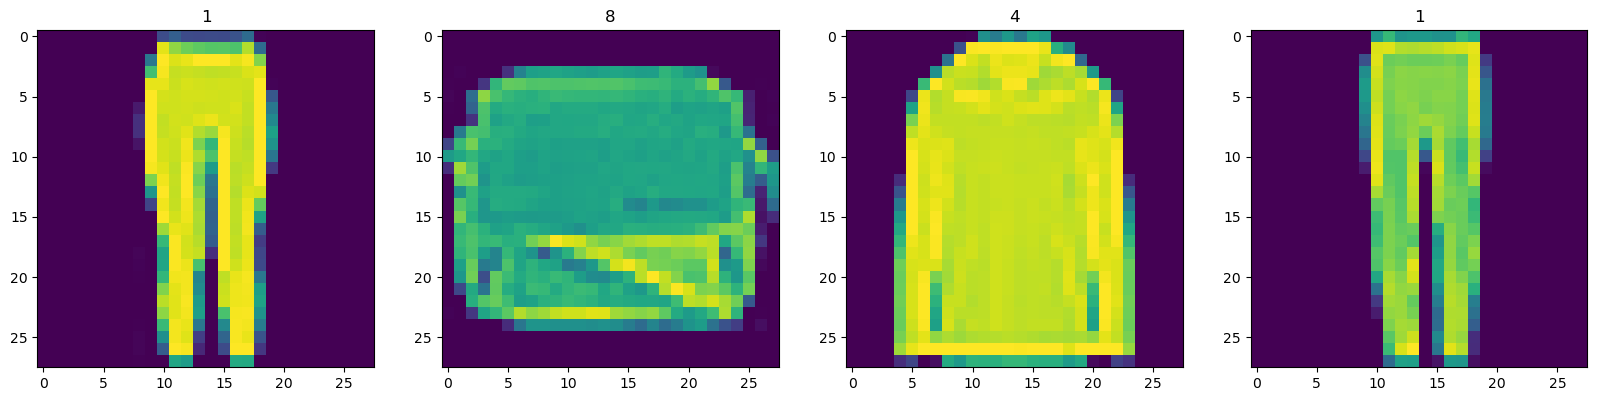

In [7]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    batch = dataiterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [8]:
def scale_images(data):
  image = data['image']
  return image / 255

In [9]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [10]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

### 3.1. Import Modelling Components

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2. Build Generator

In [30]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7x7x128
    # Beginning of generated image
    model.add(Dense(7*7*128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128,5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128,5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Down sampling blok 1
    model.add(Conv2D(128,4, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Down sampling blok 2
    model.add(Conv2D(128,4, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Conv Layer to get one channel
    model.add(Conv2D(1,4, padding='same', activation='sigmoid'))


    return model

In [33]:
generator = build_generator()
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_8 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_9 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [116]:
img = generator.predict(np.random.rand(4,128,1))
img.shape

1/1 [==============================] - 0s 18ms/step


(4, 28, 28, 1)

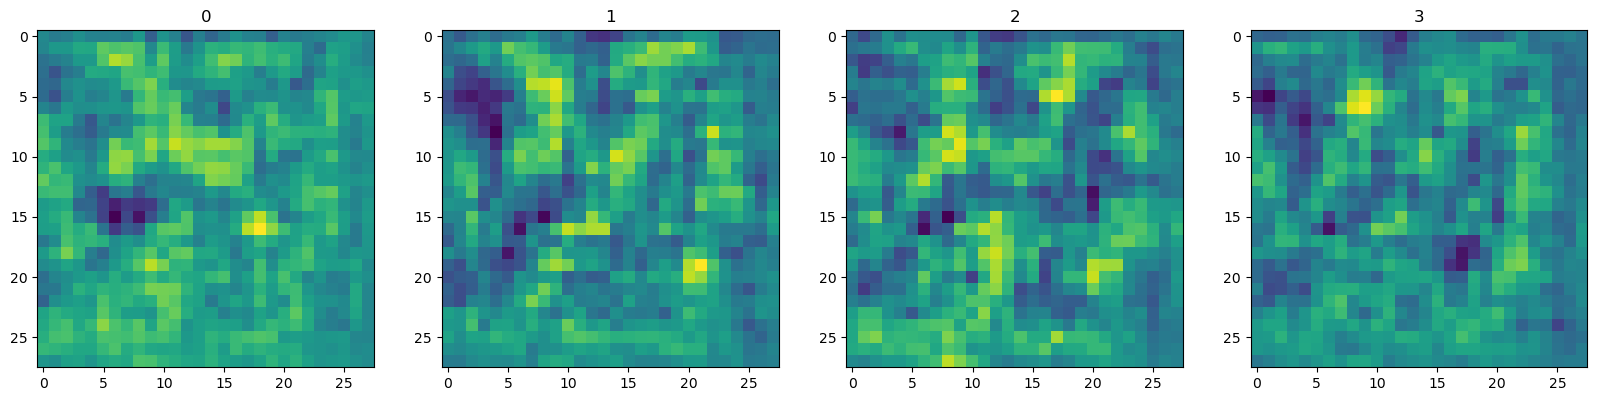

In [117]:
# Generate new Fashion Image
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, imgs in enumerate(img):
    batch = dataiterator.next()
    ax[idx].imshow(np.squeeze(imgs))
    ax[idx].title.set_text(idx)

### 3.3. Build Discriminator

In [108]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Forth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten the pass to dense layers
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))

    return model

In [109]:
disciminator = build_discriminator()
disciminator.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_11 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_12 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 16, 16, 128)     

In [115]:
# img = img[0]
# img.shape

In [121]:
# disciminator.predict(np.expand_dims(img, 0))
disciminator.predict(img)

1/1 [==============================] - 0s 14ms/step


array([[0.503679  ],
       [0.50367004],
       [0.50361323],
       [0.5036828 ]], dtype=float32)

# 4. Contruct Training Loop

### 4.1. Setup Losses and Optimizers

In [126]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [127]:
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate = 0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2. Build Subclassesed Model

In [128]:
from tensorflow.keras.models import Model

In [130]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [132]:
# Create instance of subclasses model
fashgan = FashionGAN(generator, disciminator)

In [134]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3. Build Callback

In [136]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [138]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### 4.4. Train

In [140]:
hist = fashgan.fit(ds, epochs=10, callbacks=[ModelMonitor()])

Epoch 1/10
  6/469 [..............................] - ETA: 1:23 - d_loss: 0.3882 - g_loss: 3.2120WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0851s vs `on_train_batch_end` time: 0.0948s). Check your callbacks.


469/469 [==============================] - 85s 181ms/step - d_loss: 0.3010 - g_loss: 6.0624
Epoch 2/10
469/469 [==============================] - 86s 184ms/step - d_loss: 0.2788 - g_loss: 6.5191
Epoch 3/10
469/469 [==============================] - 86s 183ms/step - d_loss: 0.2748 - g_loss: 6.2003
Epoch 4/10
469/469 [==============================] - 86s 183ms/step - d_loss: 0.2727 - g_loss: 5.9105
Epoch 5/10
469/469 [==============================] - 84s 179ms/step - d_loss: 0.3128 - g_loss: 5.1752
Epoch 6/10
469/469 [==============================] - 85s 180ms/step - d_loss: 0.2935 - g_loss: 2.5147
Epoch 7/10
469/469 [==============================] - 86s 183ms/step - d_loss: 0.2713 - g_loss: 2.7332
Epoch 8/10
469/469 [==============================] - 86s 183ms/step - d_loss: 0.2704 - g_loss: 2.7427
Epoch 9/10
469/469 [==============================] - 86s 184ms/step - d_loss: 0.2690 - g_loss: 2.7480
Epoch 10/10
469/469 [==============================] - 86s 183ms/step - d_loss: 0.26

### 4.5. Review Performance

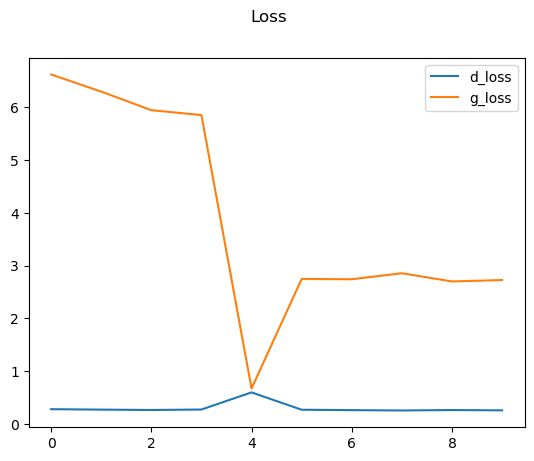

In [143]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1. Generate Images

In [ ]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [144]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 425ms/step


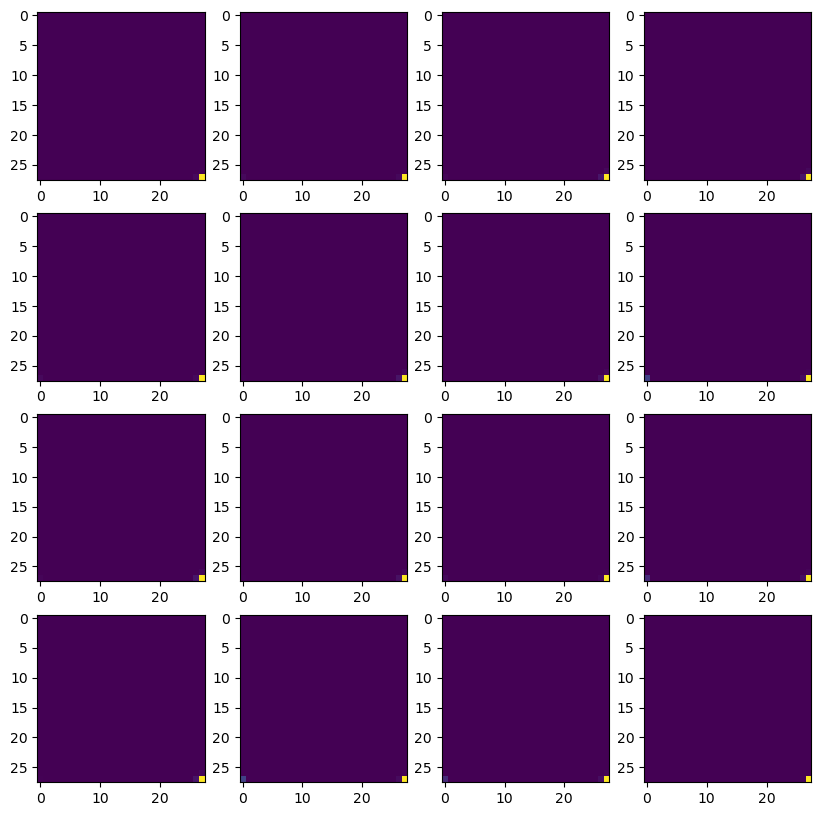

In [145]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2. Save the Model

In [146]:
generator.save('generator.h5')
disciminator.save('discriminator.h5')